### Modules Imports

In [1]:
import os
import time
import regex as re
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType, ArrayType

from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.functions import vector_to_array

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# visualization customization
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 7]

---
# Data Importation & Preprocessing

In [2]:
spark = SparkSession \
    .builder \
    .appName("Find_best_model") \
    .getOrCreate()

22/02/22 16:19:33 WARN Utils: Your hostname, Sams-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.48 instead (on interface en0)
22/02/22 16:19:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/02/22 16:19:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 16:19:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/02/22 16:19:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/02/22 16:19:34 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/02/22 16:19:34 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
df = spark.sql("SELECT * FROM parquet.`data/complete_df.parquet`")

In [4]:
df = df.withColumn(
    'opt_out',
    when(
        col('opt_out') == 'true', 1
    ).otherwise(0)
).withColumn(
    'opt_out_exercised',
    when(
        col('opt_out_exercised') == 'true', 1
    ).otherwise(0)
)

In [5]:
indexer = StringIndexer(
    inputCols=['contract_type', 'industry', 'country', 'company_type',  'recurrence'],
    outputCols=['contract_types', 'industries', 'countries', 'company_types',  'recurrences']
)
df_ml = indexer.setHandleInvalid('keep').fit(df).transform(df).drop('contract_type', 'industry', 'country', 'company_type',  'recurrence')

In [6]:
df_ml.show(1)

+---------------+----------+-------------------+-----------------+------+------------+-------+-----------------+--------------+-------+-------------+---------+------+-------+-----------+----------+--------------+---------+-------------+
|     account_id|      date|contract_start_date|contract_end_date|tenure|account_type|opt_out|opt_out_exercised|billing_bucket|matches|infringements|takedowns|closed|isChurn|recurrences|industries|contract_types|countries|company_types|
+---------------+----------+-------------------+-----------------+------+------------+-------+-----------------+--------------+-------+-------------+---------+------+-------+-----------+----------+--------------+---------+-------------+
|0011n00001vVDsy|2019-12-11|         2020-08-26|       2021-08-26|  12.0|    Customer|      0|                0|           2.0|      0|            0|        0|     0|      0|        0.0|       4.0|           1.0|      9.0|          0.0|
+---------------+----------+-------------------+----

In [7]:
columns = ['tenure', 'contract_types', 'industries', 'recurrences', 'opt_out', 'opt_out_exercised', 'company_types','matches', 'infringements', 'takedowns', 'closed', 'billing_bucket']  # 'country'

assembler = VectorAssembler(inputCols=columns, outputCol='_features').setHandleInvalid('skip')
scaler = StandardScaler(inputCol='_features' , outputCol='features')


#Create pipeline which is index the categorical columns, encode them and assemble all variables to assembler
pipeline_stages = Pipeline(stages=[assembler, scaler])

model_df = pipeline_stages.fit(df_ml).transform(df_ml)
model_df = model_df.select('date', 'account_id', 'features', col('isChurn').alias('label'))

In [8]:
model_df.show(5, False)

+----------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|date      |account_id     |features                                                                                                                                                                 |label|
+----------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|2019-12-11|0011n00001vVDsy|(12,[0,1,2,11],[2.370970559704452,1.0186624941839226,1.268945127455436,1.9177182955767853])                                                                              |0    |
|2019-12-11|0011n00001xVkPa|(12,[0,1,3],[1.97580879975371,2.0373249883678453,4.84438846020001])                                                                                     

In [9]:
model_df.count()

523251

---
#### Split the data 

In [10]:
'''
train, test = model_df.randomSplit([0.8,0.2], seed=210)
train.cache()
'''

'\ntrain, test = model_df.randomSplit([0.8,0.2], seed=210)\ntrain.cache()\n'

In [11]:
model_df = model_df.withColumn('rank', percent_rank().over(Window.partitionBy().orderBy('date')))

In [12]:
train = model_df.where('rank <= .8').drop('rank', 'date')
test = model_df.where('rank > .8').drop('rank', 'date')

---
Let's check the distribution of target variable in the training and testing set.

In [13]:
train.groupby('label').count().show()

22/02/22 16:19:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+------+
|label| count|
+-----+------+
|    0|301024|
|    1|117720|
+-----+------+



In [14]:
test.groupby('label').count().show()

22/02/22 16:19:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+-----+
|label|count|
+-----+-----+
|    0|85533|
|    1|18974|
+-----+-----+



As we can see, the distribution is skewed here. Since we are going to use trees and classification models, we don't need to worry about this.

---

# Model

#### NOTE: We could train more models for this task. I choosed these two models as an example and since my corrent machine is very old, it takes ages to train :)

In [15]:
#Create RandomForest and GradientBoosting
random_model = RandomForestClassifier(seed=210, labelCol='label')
GBT_model = GBTClassifier(seed=210, labelCol='label')

In [16]:
#Metric evaluator for predictions and isChurns
evaluator= BinaryClassificationEvaluator(labelCol='label')

In [17]:
for model_ in [random_model, GBT_model]:
    # Get the model name for representation
    model_name = model_.__class__.__name__
    
    # Fit the training data into the model
    print(f'{model_name} is training...')
    start = time.time() 
    model = model_.fit(train,)
    end = time.time()
    print(f'fitted in {end - start:.2f} seconds\n')
    
    # Prediction
    print(f'Predicting...')
    start = time.time() 
    predictions = model.transform(test)
    end = time.time()
    print(f'predicted in {end - start:.2f} seconds\n')
    
    
    #Evaluate the results of prediction    
    print('Evaluating...')
    start = time.time() 
    areaUnderROC = evaluator.evaluate(predictions,{evaluator.metricName: 'areaUnderROC'})
    end = time.time()
    
    print(f'Evaluated in {end - start:.2f} seconds')
    print(f'Test areaUnderROC: {areaUnderROC:.2f}')
    print('*'*30)

RandomForestClassifier is training...


22/02/22 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:19:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:20:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


fitted in 18.19 seconds

Predicting...
predicted in 0.04 seconds

Evaluating...


22/02/22 16:20:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Evaluated in 2.88 seconds
Test areaUnderROC: 0.92
******************************
GBTClassifier is training...


22/02/22 16:20:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


fitted in 25.04 seconds

Predicting...
predicted in 0.03 seconds

Evaluating...


22/02/22 16:20:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:20:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/02/22 16:20:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Evaluated in 1.94 seconds
Test areaUnderROC: 0.96
******************************


**I will take the random forest since the result is pretty good and the training time is less.**

In [18]:
def random_forest_tuning(train, test, numTrees=[5, 10, 20], maxDepth=[5, 10, 20]):
    """
    Tunes the RandomForestClassifier with given numTrees and maxDepth arguements
    
    INPUT: train set, test set, list of numTrees, list of maxDepth
    OUTPUT: bestmodel after tuning
    """
    #Model
    rf_model = RandomForestClassifier()
    
    #Grid for parameter tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(rf_model.numTrees, numTrees) \
        .addGrid(rf_model.maxDepth, maxDepth) \
        .build()   
    
    #3 Fold Cross Validation
    crossval = CrossValidator(
        estimator=rf_model,
        estimatorParamMaps=paramGrid,
        evaluator=BinaryClassificationEvaluator(),
        numFolds=4
    )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = crossval.fit(train)
    
    # Make predictions on test documents. cv_model uses the best model found (random forest).
    predictions = cv_model.transform(test)
    
    #Model Evaluation
    evaluator= BinaryClassificationEvaluator()
    
    areaUnderROC = evaluator.evaluate(predictions,{evaluator.metricName: 'areaUnderROC'})
    
    print('RESULTS:')
    print('*'*30)
    print(f'Test areaUnderROC: {areaUnderROC:.2f}')
    print('*'*30)
    
    return cv_model.bestModel

In [19]:
#Take the best model after parameter tuning
best_model = random_forest_tuning(train=train, test=test)

22/02/22 16:20:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:20:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:21:29 WARN DAGScheduler: Broadcasting large task binary with size 1022.7 KiB
22/02/22 16:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1151.8 KiB
22/02/22 16:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1280.4 KiB
22/02/22 16:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1401.2 KiB
22/02/22 16:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1515.6 KiB
22/02/22 16:22:16 WARN DAGScheduler: Broadcasting large task binary with size 1031.4 KiB
22/02/22 16:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1278.7 KiB
22/02/22 16:22:20 WARN DAGScheduler: Broadcasti

RESULTS:
******************************
Test areaUnderROC: 0.99
******************************


In [20]:
print(f'\nBest parameters : max depth:{best_model.getMaxDepth()}, num trees:{best_model.getNumTrees}')


Best parameters : max depth:20, num trees:20


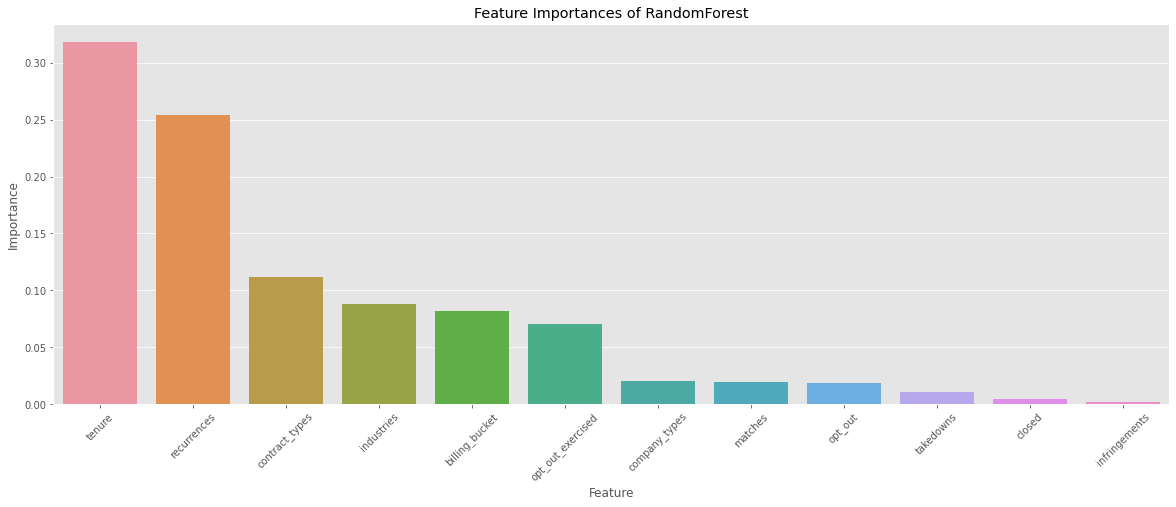

In [21]:
feat_importance = pd.DataFrame(
    list(
        zip(columns, best_model.featureImportances)
    ),
    columns= ['Feature', 'Importance']
)

plt.title('Feature Importances of RandomForest')
sns.barplot(
    x='Feature',
    y='Importance',
    data=feat_importance.sort_values(by='Importance', ascending=False).iloc[:16])
plt.xticks(rotation=45);

---
# Final Model

Let's train the model with the best parameters and create a new df with the **Client ID** and **Probability of Churn**

In [22]:
def train_random_forest(train, test, numTrees=10, maxDepth=5):
    """
    Train the RandomForestClassifier with given numTrees and maxDepth arguements
    
    INPUT: train set, test set, list of numTrees, list of maxDepth
        
    OUTPUT: Prediction df
    """
    #Model
    rf_model = RandomForestClassifier(
        maxDepth=best_model.getMaxDepth(),
        numTrees=best_model.getNumTrees
    )

    model = rf_model.fit(train)
    predictions = model.transform(test)
    
    #Model Evaluation
    evaluator= BinaryClassificationEvaluator()
       
    areaUnderROC = evaluator.evaluate(predictions,{evaluator.metricName: 'areaUnderROC'})
    
    print('RESULTS:')
    print('*'*30)
    print(f'Test areaUnderROC: {areaUnderROC:.2f}')
    print('*'*30)
    
    return predictions

In [23]:
predictions = train_random_forest(train, test)

22/02/22 16:30:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:30:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:30:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1032.6 KiB
22/02/22 16:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1293.7 KiB
22/02/22 16:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1590.0 KiB
22/02/22 16:31:25 WARN DAGScheduler: Broadcasting large task binary with size 1903.1 KiB
22/02/22 16:31:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/02/22 16:31:32 WARN DAGScheduler: Broadcasting large task bi

RESULTS:
******************************
Test areaUnderROC: 0.99
******************************


In [24]:
predictions.select(
    'account_id', 'probability', 'prediction', 'label'
).withColumn('probability', round(array_max(vector_to_array('probability')), 2)).drop_duplicates(['account_id']).show(20, False)

22/02/22 16:31:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/02/22 16:31:52 WARN DAGScheduler: Broadcasting large task binary with size 1826.0 KiB


+---------------+-----------+----------+-----+
|account_id     |probability|prediction|label|
+---------------+-----------+----------+-----+
|0011n00001vVDsy|0.88       |0.0       |0    |
|0011n00001xVkPa|1.0        |0.0       |0    |
|0011n0000259Ozz|0.98       |0.0       |0    |
|0011n0000259MXR|0.97       |0.0       |0    |
|0010Y00001YPsZx|0.96       |0.0       |0    |
|0011n000026QyzW|1.0        |0.0       |0    |
|0011n00001iasIc|1.0        |1.0       |1    |
|0011n00002ZugA7|1.0        |1.0       |1    |
|0011n0000259LTH|0.67       |1.0       |1    |
|0011n0000259LyC|1.0        |0.0       |0    |
|0011n00002NtUjN|1.0        |0.0       |0    |
|0010Y00000HCjFA|1.0        |1.0       |1    |
|0010Y00001emQAA|0.91       |0.0       |0    |
|0011n0000259L3T|0.98       |0.0       |0    |
|0011n00001pX2dS|0.98       |0.0       |0    |
|0011n00002QWe50|0.98       |0.0       |0    |
|0010Y00001ajIhj|1.0        |0.0       |0    |
|0011n0000259L0i|1.0        |1.0       |1    |
|0010Y00000JR

---
The code block blev can print the random forest tree structore. 

In [25]:
index_feature_name_tuple = [
    (0, 'tenure'), (1, 'contract_types'), (2, 'industries'), (3, 'recurrences'), (4, 'opt_out'), (5, 'opt_out_exercised'), (6, 'company_types'), (7, 'matches'), (8, 'infringements'), (9, 'takedowns'), (10, 'closed'), (11, 'billing_bucket')
]

tree_to_json = best_model.toDebugString

for (index, feature) in index_feature_name_tuple:
    pattern = '\((?P<index>feature ' + str(index) + ')' + ' (?P<rest>.*)\)'
    tree_to_json = re.sub(pattern, f'({feature} \g<rest>)', tree_to_json)

# print(tree_to_json)